![banner](https://raw.githubusercontent.com/priyammaz/HAL-DL-From-Scratch/main/src/visuals/banner.png)

# RoBERTa for Masked Language Modeling

<div>
<img src="https://raw.githubusercontent.com/priyammaz/PyTorch-Adventures/main/src/visuals/masked_language_modeling_vis.png?raw=true" width="800"/>
</div>


Today we will be implementing an updated variant of the original [BERT](https://arxiv.org/abs/1810.04805) model known as [RoBERTa](https://arxiv.org/abs/1907.11692), or Robustly Optimized BERT Approach. Before we keep going though, lets quickly review BERT!

### Bidirectional Encoder Representations from Transformers (BERT)

BERT was a model proposed in 2018, whoes whole purpose; was to learn contextual understanding from unlabeled text. There are two main differences between this model and GPT:
- BERT is bidirectional, the model looks both forwards and backwards, where GPT is causal, so it only looks backwards
- BERT uses Masked Language Modeling + Next Sentence Prediction with an Encoder Transformer instead of Causal Language Modeling with a Decoder Transformer.

### Encoders (BERT, RoBERTa, ViT)
Encoder transformers have the ability to look at the entire sequence and are bidirectional. This means when we compute attention, words can look forward and backwards, which is perfect for situations where we have the entire sequence given and we want to make some predictions about it (i.e. image classification, sentiment analysis, speech recognition, etc...)

### Decoders (GPT)
Decoder transformers only have the ability to look at the past, meaning any prediction we make for a specific time in the sequence is based only on times that came before it. This is important for tasks like time-series forecasting or language generation. When we want to generate a sequence, we can only look at the words that have come already as the future words aren't available. 

### Language Pre-Training
There are typically two types of language pretraining. Encoders use **Masked Language Modeling**. This is the process of taking a sentence, randomly removing words, and then having the model predict the missing words by looking at existing words before and after it. Decoders use **Causal Language Modeling**, where we will train a model to predict the word at time $n+1$ give all the words 1 to $n$. Today we will be looking at Causal Language Models as that is what GPT uses for pretraining. 


This is what BERT looks like!

<div>
<img src="https://raw.githubusercontent.com/priyammaz/PyTorch-Adventures/main/src/visuals/BERT_archtiecture.png?raw=true" width="800"/>
</div>

[Image Source](https://etc.cuit.columbia.edu/news/basics-language-modeling-transformers-bert)

As you can see, BERT passes in two sentences of data, along with a learnable CLS token. The CLS token perform the Next Sentence Prediction task, basically does the second sentence provided actually follow the first? The rest of the model does Masked Language Modeling, to fill in the blanks in the masked sentence. 

### How Does RoBERTa Improve on BERT?

- Train on a much larger dataset (didn't exist when BERT was made)
- Remove the Next Sentence Prediction Task, which leads to slightly better performance
- Dynamic Masking, in the dataloader, randomly mask in real time, rather than mask ahead of time and train on the same masks repeatedly. 

**Note**

RoBERTA still includes the CLS token for downstream fine-tuning in the future, but because there is no loss attached to it, there is never any gradient updated during language pre-training.

### Masked Language Model Attention

<div>
<img src="https://raw.githubusercontent.com/priyammaz/PyTorch-Adventures/main/src/visuals/mlm_attention.png?raw=true" width="800"/>
</div>

Masked language models will be a full encoder based transformer, that means all the values in the attention mechanism above will be computed. We specifically care most about the spots highlighted, how is the Masked token related to all the other words, and also how are all the other words related to the masked token (therefore bidirectional).

### How to Compute Attention

So how do we actually perform attention masking? Lets first remind ourselves what attention is doing. Here is the equation for Attention as a reminder:

$$\text{Attention}(Q,K,V) = \text{Softmax}(\frac{QK^T}{\sqrt{d_e}})V$$

So the first step is the computing the $QK^T$, where Q and K both have the shape (Sequence Length x Embedding Dimension). The output of this computation will be sequence length x sequence length. This is what it looks like!

<div>
<img src="https://raw.githubusercontent.com/priyammaz/PyTorch-Adventures/main/src/visuals/computing_attention.png?raw=true" width="800"/>
</div>

In the image above, I also applied the softmax (not shown for simplicity), so each row of the attention matrix adds up to 1 (like probabilities).

Now we can multiply our output of $QK^T$ with our $V$. This is what a regular encoder (bidirectional) attention will look like. Remember, $V_1, ... V_4$ are the projection vectors (Values) of the data, and the attention matrix is a weighted average of all of these vectors. 

**Note**

In transformers, our input $X$ goes through 3 linear projections to create $Q, K, \text{and } V$ Initially, the each vector for each word in $X$ is the embedding vector representing that word. After the attention computation, each vector for each word isn't just the embedding of that word but rather a weighted average of all the vectors in the sequence and how they are related to the word of interest. 


<div>
<img src="https://raw.githubusercontent.com/priyammaz/PyTorch-Adventures/main/src/visuals/encoder_attention_vis.png?raw=true" width="800"/>
</div>


### Sequence Padding and Attention Masking

One typical consideration for models like this is, when we pass in sentences of data, different sentences have different lengths. To create a matrix of tokens, we need to make sure all the sequences are the same, therefore we have to pad the shorter sequences to the longer ones. This is what the padding looks like!

<div>
<img src="https://raw.githubusercontent.com/priyammaz/PyTorch-Adventures/main/src/visuals/sequence_padding.png?raw=true" width="800"/>
</div>

Now the pad tokens are just fillers, they don't add any information at all to the data. To deal with this, we need to make sure that when we compute attention, these pad tokens are ignored. This is very similar to the Causal Mask in [GPT](https://github.com/priyammaz/HAL-DL-From-Scratch/tree/main/PyTorch%20for%20NLP/GPT), and we will be doing exactly what we did there, fill in the masked locations with $-\infty$ before softmax is computed. Lets take a quick look at this for one of the sentences above. 

<div>
<img src="https://raw.githubusercontent.com/priyammaz/PyTorch-Adventures/main/src/visuals/padding_attention_mask.png?raw=true" width="800"/>
</div>

You can see that we zero out the columns of our attention mask that has padding tokens, but not the row. The reason for this is, the model should learn the relation of how the padding tokens are related to the words (this is most likely just positional information that padding is at the end), but it should not learn how other words are related to padding, as the padding adds no semantic meaning. This is why, when multiplying by our values, we have zeroed out the attention weights of the 4th column, as when computing weighted averages of how one word is related to all others, the padding token is not included. 



## Computing the Reweighted Padded Attention Mask

Lets create some numbers so we can get a better idea of how this works. Let the tokens be $X = [10, 2, \text{<pad>}]$, so the third token is a padding token. Lets then also pretend, we pass this to our RoBERTa model, and when we go to compute our attention $QK^T$, the raw output before the softmax is below.

\begin{equation}
\begin{bmatrix}
  7       & -8   & 6  \\
  -3       & 2   & 4   \\
  1       & 6  & -2   \\
\end{bmatrix}
\end{equation}

Remember, the equation for softmax is:

$$\text{Softmax}(\vec{x}) = \frac{e^{x_i}}{\sum_{j=1}^N{e^{x_j}}}$$

Then, if we ignore padding and everything right now, we can compute softmax for row of the matrix above:

\begin{equation}
\text{Softmax}
\begin{bmatrix}
  7       & -8   & 6  \\
  -3       & 2   & 4   \\
  1       & 6  & -2   \\
\end{bmatrix} = 
\begin{bmatrix}
  \frac{e^{7}}{e^{7}+e^{-8}+e^{6}}       & \frac{e^{-8}}{e^{7}+e^{-8}+e^{6}}   & \frac{e^{6}}{e^{7}+e^{-8}+e^{6}}  \\
  \frac{e^{-3}}{e^{-3}+e^{2}+e^{4}}       & \frac{e^{2}}{e^{-3}+e^{2}+e^{4}}   & \frac{e^{4}}{e^{-3}+e^{2}+e^{4}}  \\
  \frac{e^{1}}{e^{1}+e^{6}+e^{-2}}       & \frac{e^{6}}{e^{1}+e^{6}+e^{-2}}   & \frac{e^{-2}}{e^{1}+e^{6}+e^{-2}}  \\
\end{bmatrix} = 
\begin{bmatrix}
  0.73       & 0.0000002   & 0.27   \\
  0.0008       & 0.12   & 0.88 \\
  0.007       & 0.99  & 0.003  \\
\end{bmatrix}
\end{equation}

But what we need is to mask out all the tokens in this matrix related to padding. Just like we did in [GPT](https://github.com/priyammaz/HAL-DL-From-Scratch/tree/main/PyTorch%20for%20NLP/GPT), we will fill in the indexes of the that we want to mask with $-\infty$. If only the last token was a padding token in our sequence, then the attention before the softmax should be written as:

\begin{equation}
\begin{bmatrix}
  7       & -8   & -\infty  \\
  -3       & 2   & -\infty   \\
  1       & 6  & -\infty  \\
\end{bmatrix}
\end{equation}


Taking the softmax of the rows of this matrix then gives:

\begin{equation}
\text{Softmax}
\begin{bmatrix}
 7       & -8   & -\infty  \\
  -3       & 2   & -\infty   \\
  1       & 6  & -\infty  \\
\end{bmatrix} = 
\begin{bmatrix}
  1       & 0   & 0  \\
  0.0067  & 0.9933 & 0   \\
  0.0067       & 0.9933  & 0  \\
\end{bmatrix}
\end{equation}

Which is exactly what we want! Therefore, when computing attention, we need to know which tokens are padding tokens in our data, and then go ahead and perform this computation on our attention output before multiplying with values.


### Masked Language Modeling Logic

Last piece! How do we do the masked language modeling? We will follow exactly what RoBERTa and BERT had done:
- We will randomly mask out 15 percent of the words in our sentence. Of the 15 percent selected to be masked we will:
    - 80% of the time we will replace it with a mask token
    - 10% of the time it will be replaced with some random token (not mask token)
    - 10% of the time it will be kept the same
 
The reason for this logic is, in the real world, there are no mask tokens, just regular sentences. This way the model will have some experience understanding that a word is misplaced (a random word inserted) or that a word is correct. Regardless, the masked words will be predicted, where most of the times the input is the mask token, but sometimes it will just be exactly the word it was to begin with or some random word. 


### Tokenizer

In our case, we will use the RoBERTa tokenizer found in Huggingface! RoBERTA tokenizer is exactly the same as the GPT2 Tokenizer, except it includes some of these special tokens like the Mask and Pad tokens that we need!



In [1]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import torch
import torch.nn as nn
from torch import optim
from torch.utils.data import Dataset, DataLoader
from transformers import RobertaTokenizer, get_cosine_schedule_with_warmup

In [2]:
tokenizer = RobertaTokenizer.from_pretrained("FacebookAI/roberta-base")

print("Special Tokens in Tokenizer")
special_tokens = tokenizer.special_tokens_map
print(special_tokens)

special_token_idx = {}
for token in special_tokens.values():
    special_token_idx[token] = tokenizer.encode(token, add_special_tokens=False)[0]

print("Special Token Index")
print(special_token_idx)


### Get Indexes of All Types of Tokens ###
all_tokens_idx = list(range(tokenizer.vocab_size))
all_special_tokens_idx = sorted(list(special_token_idx.values()))
all_non_special_tokens_idx = [tok for tok in all_tokens_idx if tok not in all_special_tokens_idx]


Special Tokens in Tokenizer
{'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'}
Special Token Index
{'<s>': 0, '</s>': 2, '<unk>': 3, '<pad>': 1, '<mask>': 50264}


### Prepare Dataset

Lets perpare our Harry Potter dataset again! In this case, we will split our data into sentences, and then grab 5 sentences per chunk for our model. Theres tons of ways to do this, but I will just split on the periods and then put them back together in chunks. This is definitely not perfect as we will split on periods that are not end of sentences (Mr., Mrs., ...) but this should be ok for now. 

In [3]:
path_to_data = "../../data/harry_potter_txt/"

text_files = os.listdir(path_to_data)

all_text = ""
for book in text_files:
    with open(os.path.join(path_to_data, book), "r") as f:
        text = f.readlines() # Read in all lines
        text = [line for line in text if "Page" not in line] # Remove lines with Page Numbers
        text = " ".join(text).replace("\n", "") # Remove all newline characters
        text = [word for word in text.split(" ") if len(word) > 0] # Remove all empty characters
        text = " ".join(text) # Combined lightly cleaned text
        all_text += text

### Split Data by "sentences" ###
all_text = all_text.split(".")

### Grab 5 Sentences at a time and put them together by the period ###
all_text_chunked = [".".join(all_text[i:i+5]) for i in range(0, len(all_text), 5)]

### Tokenize all the text! ###
tokenized_text = [tokenizer.encode(text) for text in all_text_chunked]

Token indices sequence length is longer than the specified maximum sequence length for this model (601 > 512). Running this sequence through the model will result in indexing errors


### Write a Dataset Class

Now that we have our tokenized data ready, we need to write a dataloader. This dataloader should perform a few things:

- Padding to the longest sequence length
- Masking with the ratios shown above (ensuring that we dont mask any special tokens or padding tokens)

#### What are we predicting?

Quick example: 

Lets pretend our input to the model is: [10, 5, 2, 6, 1, 4, 13, 1, 4, <pad>, <pad>]. 

After masking it can be something like [10, "[mask]", 2, 6, 1, "[mask]", 13, 1, 4, "[pad]", "[pad]"].

Then our final prediction vector is [-100, 5, -100, -100, -100, 4, -100, -100, -100, -100, -100]

Where did all the -100 come from? This is a classification problem in the end so we will be using CrossEntropyLoss. In the [documentation](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html), we see that there is a argument called *ignore_index=-100*. When we compute loss, we only want to do this for the masked tokens, and ignore the unmasked ones. This is why in our label, we will set the masked token to the index its supposed to predict, and everything else as -100!

In [5]:
class MaskedLMLoader(Dataset):
    def __init__(self, tokenized_data, max_seq_len=100, masking_ratio=0.15):
        self.data = tokenized_data
        self.mask_ratio = masking_ratio
        self.max_seq_len = max_seq_len
        
    def __len__(self):
        return len(self.data)

    def _random_mask_text(self, tokens):

        ### Create Random Uniform Sample Tensor ###
        random_masking = torch.rand(*tokens.shape)

        ### Set Value of Special Tokens to 1 so we DONT MASK THEM ###
        special_tokens = torch.tensor(tokenizer.get_special_tokens_mask(tokens, already_has_special_tokens=True))
        random_masking[special_tokens==1] = 1

        ### Get Boolean of Words under Masking Threshold ###
        random_masking = (random_masking < self.mask_ratio)

        ### Create Labels ###
        labels = torch.full((tokens.shape), -100)
        labels[random_masking] = tokens[random_masking]

        ### Get Indexes of True ###
        random_selected_idx = random_masking.nonzero()

        ### 80% Of the Time Replace with Mask Token ###
        masking_flag = torch.rand(*random_selected_idx.shape)
        masking_flag = (masking_flag<0.8)
        selected_idx_for_masking = random_selected_idx[masking_flag]

        ### Seperate out remaining indexes to be assigned ###
        unselected_idx_for_masking = random_selected_idx[~masking_flag]

        ### 10% of the time (or 50 percent of the remaining 20%) we fill with random token ###
        ### The remaining times, leave the text as is ###
        masking_flag = torch.rand(*unselected_idx_for_masking.shape)
        masking_flag = (masking_flag<0.5)
        selected_idx_for_random_filling = unselected_idx_for_masking[masking_flag]
        selected_idx_to_be_left_alone = unselected_idx_for_masking[~masking_flag]
        
        ### Fill Mask Tokens ###
        if len(selected_idx_for_masking) > 0:
            tokens[selected_idx_for_masking] = special_token_idx["<mask>"]
        
        ### Fill Random Tokens ###
        if len(selected_idx_for_random_filling) > 0:
            randomly_selected_tokens = torch.tensor(random.sample(all_non_special_tokens_idx, len(selected_idx_for_random_filling)))
            tokens[selected_idx_for_random_filling] = randomly_selected_tokens
        
        
        return tokens, labels
        
    def __getitem__(self, idx):
        data = torch.tensor(self.data[idx])

        ### Make sure sequence is within context length ###
        if len(data) > self.max_seq_len:
            rand_start_idx = random.choice(list(range(len(data) - self.max_seq_len)))
            end_idx = rand_start_idx + self.max_seq_len
            data = data[rand_start_idx:end_idx]
  
        ### Uniform Random Masking ###
        masked_tokens, label = self._random_mask_text(data)

        return masked_tokens, label

mlm = MaskedLMLoader(tokenized_text)

for masked_tokens, labels in mlm:
    print(masked_tokens)
    print(labels)
    break

tensor([    0,    73,  1941,  9963,   975, 13387,   226,  6372,  1691,   427,
            4,     8,  3801,     4,   211, 50264,   607,     6,     9,   346,
          237, 50264, 50264, 18068,  3936,     6,    58,  2602,     7,   224,
           14,    51,    58,  6683,  2340,     6,  3392,    47, 50264,   203,
            4,   252,    58,     5, 50264,    82,    47,    17,    27,   417,
         1057,     7, 50264, 50264,    11,   932,  7782,    50, 12754,     6,
          142,    51,    95, 50264,    17, 50264,    90,   946,    19,   215,
        33736,     4,   427,     2])
tensor([ -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
         -100,  -100,  -100,  -100,  -100,  4668,  -100,  -100,  -100,  -100,
         -100,     6,  9522,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
         -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,   182,  -100,
         -100,  -100,  -100,  -100,    94,  -100,  -100,  -100,  -100,  -100,
         -100,  -100,    28

### Write a DataLoader Class

Now that we have our masking and labels generation ready to go for our dataset, we now need to write a DataLoader! In this dataloader, needs some additional logic though:

- Data collation to pad to longest sequence so we can stack our tensors together
- Pad the labels with more -100 as well, because we dont predict on padding tokens 
- Padding mask which will be used as our attention mask later

In [6]:
def collate_fn(batch):

    ### Grab Tokens and their Labels ###
    token_samples = []
    label_samples =[]

    for token, label in batch:
        token_samples.append(token)
        label_samples.append(label)

    ### Get Seq Len of Each Token along with Max Length ###
    sequence_lengths = [len(tok) for tok in token_samples]
    max_seq_len = max(sequence_lengths)

    ### Append Padding Tokens to Token Samples, store padding masks and append more -100 for the labels ###
    padding_masks = []
    for idx in range(len(token_samples)):
        sample = token_samples[idx]
        seq_len = len(sample)
        diff = max_seq_len - seq_len

        if diff > 0:

            ### Append Padding to Each Sequence ###
            padding = torch.tensor([special_token_idx["<pad>"] for _ in range(diff)])
            sample = torch.concatenate((sample, padding))
            token_samples[idx] = sample
            
            ### Append -100 to Labels (we dont predict padding masks) ###
            label_padding = torch.tensor([-100 for _ in range(diff)])
            label_samples[idx] = torch.concatenate((label_samples[idx], label_padding))

            ### Store Padding Mask ###
            padding_mask = (sample==special_token_idx["<pad>"])
            padding_masks.append(padding_mask)

        else:

            ### Padding Mask (with no padding) for longest sequence ###
            padding_masks.append(torch.zeros(max_seq_len))

    token_samples = torch.stack(token_samples)
    label_samples = torch.stack(label_samples)
    padding_masks = torch.stack(padding_masks)

    assert token_samples.shape == label_samples.shape == padding_masks.shape
    
    batch = {"input_ids": token_samples, 
             "labels": label_samples, 
             "attention_mask": padding_masks.bool()}

    return batch
    
### Test DataLoader ###
dataloader = DataLoader(mlm, batch_size=16, collate_fn=collate_fn)

for batch in dataloader:
    print(batch["input_ids"])
    print(batch["labels"])
    print(batch["attention_mask"])
    break

tensor([[    0,    73,  1941,  ...,     1,     1,     1],
        [    0,   211,  4668,  ...,    49,  2979,    89],
        [    0,    20, 50264,  ...,     1,     1,     1],
        ...,
        [    0,  1993,     9,  ...,     1,     1,     1],
        [   91,    21,    11,  ...,    27,    90,   192],
        [    0,    85,    21,  ...,   357,     9,    24]])
tensor([[-100, -100, -100,  ..., -100, -100, -100],
        [-100, -100, -100,  ..., -100, -100, -100],
        [-100, -100,  211,  ..., -100, -100, -100],
        ...,
        [-100, -100, -100,  ..., -100, -100, -100],
        [-100, -100, -100,  ..., -100, -100, -100],
        [-100, -100, -100,  ..., -100, -100, -100]])
tensor([[False, False, False,  ...,  True,  True,  True],
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ...,  True,  True,  True],
        ...,
        [False, False, False,  ...,  True,  True,  True],
        [False, False, False,  ..., False, False, False],
        [

### Attention Mechanism 

Now that we have completed all of our data prep, its time to move onto the attention mechanism implementation! This should be almost identical to the [Vision Transformer](https://github.com/priyammaz/HAL-DL-From-Scratch/tree/main/PyTorch%20for%20Computer%20Vision/Vision%20Transformer) implementation, with the additional logic for masking added in, which will be similar to our [GPT](https://github.com/priyammaz/HAL-DL-From-Scratch/tree/main/PyTorch%20for%20NLP/GPT) implementation. 

In [7]:
class SelfAttentionEncoder(nn.Module):
  def __init__(self,
               embed_dim=768,
               num_heads=12, 
               attn_p=0,
               proj_p=0):

    """
    Args:

        embed_dim: What is the embedding dimension of each embedding vector
        num_heads: How many heads of attention do we want?
        attn_p: Dropout probability on Attention
        proj_p: Dropout probability on projection matrix
    """
    super(SelfAttentionEncoder, self).__init__()
    assert embed_dim % num_heads == 0
    self.num_heads = num_heads
    self.head_dim = int(embed_dim / num_heads)
    self.scale = self.head_dim ** -0.5

    self.qkv = nn.Linear(embed_dim, embed_dim*3)
    self.attn_p = attn_p
    self.attn_drop = nn.Dropout(attn_p)
    self.proj = nn.Linear(embed_dim, embed_dim)
    self.proj_drop = nn.Dropout(proj_p)

  def forward(self, x, attention_mask=None):
    batch_size, seq_len, embed_dim = x.shape
    qkv = self.qkv(x).reshape(batch_size, seq_len, 3, self.num_heads, self.head_dim)
    qkv = qkv.permute(2,0,3,1,4)
    q,k,v = qkv.unbind(0)

    # B x H x S x S
    attn = (q @ k.transpose(-2,-1)) * self.scale

    ####################################################################################
    ### FILL ATTENTION MASK WITH -Infinity ###

    if attention_mask is not None:
        ### We Need to Unsqueeze Attention Mask to have placeholder dimensions for Num Heads and Seq Len ###

        # B, S -> B, 1, 1, S
        attention_mask = attention_mask.unsqueeze(1).unsqueeze(1)
        attn = attn.masked_fill(attention_mask, float('-inf'))

    ####################################################################################

    attn = attn.softmax(dim=-1)
    attn = self.attn_drop(attn)
    x = attn @ v

    x = x.transpose(1,2).reshape(batch_size, seq_len, embed_dim)
    x = self.proj(x)
    x = self.proj_drop(x)
      
    return x

### Lets test Attention Mechanism ###
rand_x = torch.randn(2,5,16)
padding = torch.tensor([[False, False, False, True, True], 
                        [False, False, False, False, False]])

a = SelfAttentionEncoder(embed_dim=16, num_heads=4)
out = a(rand_x, padding)
print(out.shape)

torch.Size([2, 5, 16])


### Define the Rest of The Transformer

All we have left is to implement the rest of the model! Again, this should be very similar to the [Vision Transformer](https://github.com/priyammaz/HAL-DL-From-Scratch/tree/main/PyTorch%20for%20Computer%20Vision/Vision%20Transformer) and [GPT](https://github.com/priyammaz/HAL-DL-From-Scratch/tree/main/PyTorch%20for%20NLP/GPT)!

In [8]:
########################################
### DEFINE THE MULTILAYER PERCEPTRON ###
########################################

class MLP(nn.Module):
    def __init__(self, 
                 in_features,
                 hidden_features,
                 out_features,
                 act_layer=nn.GELU,
                 mlp_p=0):


        super(MLP, self).__init__()
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = act_layer()
        self.drop1 = nn.Dropout(mlp_p)
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop2 = nn.Dropout(mlp_p)
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop1(x)
        x = self.fc2(x)
        x = self.drop2(x)
        return x

################################################################
### PUT ATTENTION AND MLP TOGETHER WITH RESIDUAL CONNECTIONS ###
################################################################

class Block(nn.Module):
    def __init__(self, 
                 embed_dim=768, 
                 num_heads=12, 
                 mlp_ratio=4, 
                 proj_p=0., 
                 attn_p=0., 
                 mlp_p=0., 
                 act_layer=nn.GELU, 
                 norm_layer=nn.LayerNorm):

        super().__init__()
        self.norm1 = norm_layer(embed_dim, eps=1e-6)
        self.attn = SelfAttentionEncoder(embed_dim=embed_dim,
                                         num_heads=num_heads, 
                                         attn_p=attn_p,
                                         proj_p=proj_p)


        self.norm2 = norm_layer(embed_dim, eps=1e-6)
        self.mlp = MLP(in_features=embed_dim,
                       hidden_features=int(embed_dim*mlp_ratio),
                       out_features=embed_dim,
                       act_layer=act_layer,
                       mlp_p=mlp_p)

    def forward(self, x, attention_mask=None):
        x = x + self.attn(self.norm1(x), attention_mask)
        x = x + self.mlp(self.norm2(x))
        return x

### Write RoBERTa

The final step! Lets put it all together to have our RoBERTa class! This isn't exactly RoBERTa, it is smaller, and I think some of the activations are different, but most of it should be pretty close! Here are the things we will be doing here:

- Word Embeddings: We need to create an embedding matrix for our token embeddings
- Positional Embeddings: We need a second embedding matrix for the positional encodings. We could have used Sin-Cosine embeddings like the original [Attention is All You Need](https://arxiv.org/abs/1706.03762) paper, but we will used learned embeddings in this case. Theres lots of options though like [Rotary Embeddings](https://arxiv.org/abs/2104.09864) or [ALiBi](https://arxiv.org/abs/2108.12409) that are definitely better, but this is a start! **Also note, if our sequence length is 512, then our total number of positions is 513 due to the extra CLS token that also needs positional information. 
- CLS Token, although not used in our model for pretraining right now, we will leave it as it would be necessary for downstream finetuning. 
- Blocks: Stack of our transformer blocks
- Prediction Head: For each embedding vector, we need to predict the next work, so this will predict our vocab size of the tokenizer.

#### Weight Sharing
Intuitively, the weight matrix that takes in indexes for tokens and converts to the embedding vectors and the prediction head that takes embedding vectors and predicts the token indexes are doing the same thing. A trick we can use is weight sharing, just make the weights of the word embeddings equal to the weights of the prediction heads, as these vectors have to serve the same purpose!

#### Weight Initialization Strategy
There is a lot of work in how different weight initialization effects transformers. We will just go with the typical one that I have seen of truncated normal initialization on all weight layers and biases set to 0. 

In [9]:
class RoBERTa(nn.Module):
    def __init__(self, 
                 max_seq_len=512,
                 vocab_size=tokenizer.vocab_size,
                 embed_dim=768, 
                 depth=12, 
                 num_heads=12, 
                 mlp_ratio=4, 
                 attn_p=0., 
                 mlp_p=0., 
                 proj_p=0., 
                 pos_p=0., 
                 act_layer=nn.GELU, 
                 norm_layer=nn.LayerNorm):

        super(RoBERTa, self).__init__()

        self.max_seq_len = max_seq_len
        self.embeddings = nn.Embedding(vocab_size, embed_dim)
        self.cls_token = nn.Parameter(torch.zeros(1,1,embed_dim))
        self.pos_embed = nn.Embedding(max_seq_len+1, embed_dim)
        self.pos_drop = nn.Dropout(pos_p)

        self.blocks = nn.ModuleList(
            [
                Block(embed_dim=embed_dim, 
                      num_heads=num_heads, 
                      mlp_ratio=mlp_ratio, 
                      proj_p=proj_p, 
                      attn_p=attn_p, 
                      mlp_p=mlp_p, 
                      act_layer=act_layer, 
                      norm_layer=norm_layer)

                for _ in range(depth)
            ]
        )

        self.norm = norm_layer(embed_dim)
        self.head = nn.Linear(embed_dim, vocab_size)


    def forward(self, x, attention_mask):
        device = x.device

        batch_size, seq_len = x.shape

        ### If we have too long of a sequence length, grab the last chunk ###
        if seq_len > self.max_seq_len:
            x = x[:, -self.max_seq_len:]

        ### We only need the positional information upto the length of data we have plus CLS token ###
        avail_idx = torch.arange(0, seq_len+1, dtype=torch.long, device=device)

        ### Embed all the Tokens ###
        tok_emb = self.embeddings(x)

        ### Concatenate on the CLSL Token ###
        cls_token = self.cls_token.expand(batch_size, -1, -1) # (batch, 1, embed_dim)
        tok_emb = torch.cat((cls_token, tok_emb), dim=1) 

        ### Add positional information ###
        pos_emb = self.pos_embed(avail_idx)
        x = tok_emb + pos_emb
        x = self.pos_drop(x)

        for block in self.blocks:
            x = block(x)

        ### Slice Off CLS token ###
        cls_token_final = x[:, 0] 

        ### Slice off Remaining Tokens ###
        x = x[:, 1:]

        ### MLM Prediction Head ###
        x = self.head(x)
        
        return x

        

### Test Model ###
rand_x = torch.randint(0,10, (2,5))
padding = torch.tensor([[False, False, False, True, True], 
                        [False, False, False, False, False]])

m = RoBERTa()
out = m(rand_x, padding)
print(out.shape)

torch.Size([2, 5, 50265])


In [10]:
### DEFINE TRAINING PARAMETERS ###
iterations = 15000
max_len = 100
evaluate_interval = 100
embedding_dim = 384
depth = 4
num_heads = 4
lr = 0.0005
batch_size = 64

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

### DEFINE MODEL AND OPTIMIZER ###
model = RoBERTa(max_seq_len=max_len, 
                embed_dim=embedding_dim, 
                depth=depth, 
                num_heads=num_heads, 
                attn_p=0.1, 
                mlp_p=0.1, 
                proj_p=0.1, 
                pos_p=0.1)

model = model.to(DEVICE)
optimizer = optim.AdamW(model.parameters(), lr=lr)

### DEFINE LOSS FUNCTION ###
loss_fn = nn.CrossEntropyLoss()

### Build DataLoader ###
dataset = MaskedLMLoader(tokenized_text, max_seq_len=max_len)
trainset, testset = torch.utils.data.random_split(dataset, [int(0.95*len(dataset)),int(len(dataset) - int(0.95*len(dataset)))])
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)

### Define Scheduler ###
scheduler = get_cosine_schedule_with_warmup(optimizer=optimizer, 
                                            num_warmup_steps=1500, 
                                            num_training_steps=iterations)


### Some Training Helper Stuff ###
train = True
completed_steps = 0
all_training_losses, all_validation_losses = [], []
training_losses, validation_losses = [], []
progress_bar = tqdm(range(iterations))

while train:

    for batch in trainloader:

        ### Grab Batch Information ###
        inputs, labels, mask = batch["input_ids"], batch["labels"], batch["attention_mask"]
        inputs, labels, mask = inputs.to(DEVICE), labels.to(DEVICE), mask.to(DEVICE)

        ### Pass Data through Model ###
        prediction = model(inputs, mask)

        ### Compute Loss (automatically on non -100 values)
        prediction = prediction.reshape(-1, prediction.shape[-1]) # (B*S, E)
        labels = labels.reshape(-1) # (B*S)
        loss = loss_fn(prediction, labels)
        training_losses.append(loss.item())

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
        
        completed_steps += 1
        progress_bar.update(1)
            
        if completed_steps % evaluate_interval == 0:
            with torch.no_grad():
                for batch in testloader:
                    inputs, labels, mask = batch["input_ids"], batch["labels"], batch["attention_mask"]
                    inputs, labels, mask = inputs.to(DEVICE), labels.to(DEVICE), mask.to(DEVICE)
                    prediction = model(inputs, mask)
                    prediction = prediction.reshape(-1, prediction.shape[-1]) # (B*S, E)
                    labels = labels.reshape(-1) # (B*S)
                    loss = loss_fn(prediction, labels)
                    validation_losses.append(loss.item())

            avg_training_loss = np.mean(training_losses)
            avg_eval_loss = np.mean(validation_losses)
            
            print(f"Iteration {completed_steps} Training Loss:", avg_training_loss, "Validation Loss:", avg_eval_loss)

            all_training_losses.append(avg_training_loss)
            all_validation_losses.append(avg_eval_loss)

            training_losses = []
            validation_losses = []

        if completed_steps >= iterations:
            train = False
            break


  0%|          | 0/15000 [00:00<?, ?it/s]

Iteration 100 Training Loss: 10.34432785987854 Validation Loss: 8.520377499716622
Iteration 200 Training Loss: 7.274836959838868 Validation Loss: 6.715031385421753
Iteration 300 Training Loss: 6.590062284469605 Validation Loss: 6.529433625085013
Iteration 400 Training Loss: 6.435049891471863 Validation Loss: 6.390048095158169
Iteration 500 Training Loss: 6.358944272994995 Validation Loss: 6.326058047158377
Iteration 600 Training Loss: 6.1937928390502925 Validation Loss: 6.066775321960449
Iteration 700 Training Loss: 5.879653730392456 Validation Loss: 5.68797162600926
Iteration 800 Training Loss: 5.528706216812134 Validation Loss: 5.381109169551304
Iteration 900 Training Loss: 5.21749849319458 Validation Loss: 5.1651431151798795
Iteration 1000 Training Loss: 5.03770667552948 Validation Loss: 4.941173144749233
Iteration 1100 Training Loss: 4.803663349151611 Validation Loss: 4.854219198226929
Iteration 1200 Training Loss: 4.693519849777221 Validation Loss: 4.736985240663801
Iteration 1300

### Lets take a look at our Training Curve!

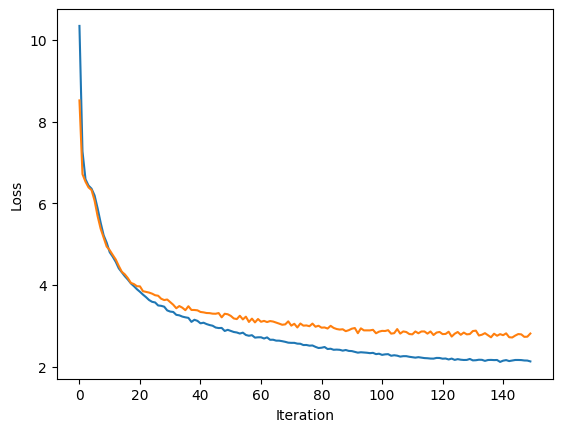

In [11]:
plt.plot(all_training_losses)
plt.plot(all_validation_losses)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

There is clear signs of overfitting, but the model did learn something! To match the original RoBERTa implementation we would need significantly larger datasets, batch sizes, and computational resources. But this should give a pretty good intuition about what is going on and how you can also implement this! But there is something we can try with the model, why don't we play fill in the blank?


### Trying the Model Out!

We will pass in a sentence with a mask, and then plot the top 5 things the model predicts to put there!

In [16]:
def fill_in_the_gap(masked_sentence, k=3):

    ### Place in Evaluation Mode ###
    model.eval()
    
    ### Encode Text and put on GPU ###
    encoded_text = tokenizer.encode(masked_sentence)
    input_tokens = torch.tensor(encoded_text).to(DEVICE)

    ### Get which token is the mask token, we want to look at the predictions for that only! ###
    masked_token_index = (input_tokens == special_token_idx["<mask>"]).nonzero().item()

    ### Pass through model, we dont have any attention mask because its just one sentence ###
    with torch.no_grad():
        output = model(input_tokens.unsqueeze(0), attention_mask=None)

    ### Grab the index of the masked token and apply softmax ###
    predicted_output = output[0, masked_token_index]

    ### Grab Top K predicted Words ###
    top_k_predicted = torch.topk(predicted_output, k=k).indices

    ### Decode and print out the predicted words! ###
    predicted_words = tokenizer.decode(top_k_predicted.tolist()).strip().split(" ")

    return predicted_words


In [17]:
sentence = "The Wizarding <mask> is a wonderful place to visit"
fill_in_the_gap(masked_sentence=sentence)

['community', 'world', 'order']

In [20]:
sentence = "Lord Voldemort is a <mask> wizard"
fill_in_the_gap(masked_sentence=sentence)

['powerful', 'true', 'great']

### Thats It!
These seem like reasonable generations! There is a lot of improvement that can be made to this model, mostly in scale, but this is the most minimal implementation of a Masked Language Model that I could make!